<a href="https://colab.research.google.com/github/lipeng2021/-python1/blob/main/5_8_NIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import torch.nn as nn
from IPython import display
import torchvision
import torchvision.transforms as transforms
import time
FILENAME = '/home/lp'
device = torch.device('cuda'if torch.cuda.is_available()else 'cpu')
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [23]:
def nin_block(in_channels,out_channels,kernel_size,stride,padding):
  blk=nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
      nn.ReLU(),
      nn.Conv2d(out_channels,out_channels,kernel_size=1),
      nn.ReLU(),
      nn.Conv2d(out_channels,out_channels,kernel_size=1),
      nn.ReLU()
  )
  return blk

In [24]:
class GlobalAveragePool(nn.Module):
  def __init__(self):
    super(GlobalAveragePool,self).__init__()
  def forward(self,x):
    y = F.avg_pool2d(x,kernel_size=x.size()[2:])
    return y

In [25]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer,self).__init__()
  def forward(self,x):
    return x.view(x.shape[0],-1)

In [26]:
from torch.nn.modules.conv import Conv2d
net = nn.Sequential(
    nin_block(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=0),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=2),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Dropout(0.5),
    nin_block(in_channels=384,out_channels=10,kernel_size=3,stride=1,padding=1),
    GlobalAveragePool(),
    FlattenLayer(),
)

In [27]:
x = torch.rand(1,1,224,224)
for name,blk in net.named_children():
  x = blk(x)
  print(name,'output shape:',x.shape)

0 output shape: torch.Size([1, 96, 54, 54])
1 output shape: torch.Size([1, 96, 26, 26])
2 output shape: torch.Size([1, 256, 26, 26])
3 output shape: torch.Size([1, 256, 12, 12])
4 output shape: torch.Size([1, 384, 12, 12])
5 output shape: torch.Size([1, 384, 5, 5])
6 output shape: torch.Size([1, 384, 5, 5])
7 output shape: torch.Size([1, 10, 5, 5])
8 output shape: torch.Size([1, 10, 1, 1])
9 output shape: torch.Size([1, 10])


In [28]:
def load_data_fashion_mnist(batch_size,resize=None,root=FILENAME):
  trans =[]
  if resize:
    trans.append(transforms.Resize(size=resize))
  trans.append(transforms.ToTensor())
  transform = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root=root,train=True,transform=transform,download=True)
  mnist_test = torchvision.datasets.FashionMNIST(root=root,train=False,transform=transform,download=True)
  train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=2)
  test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=2)
  return train_iter,test_iter
batch_size=128
train_iter,test_iter = load_data_fashion_mnist(batch_size,resize=224)

In [29]:
def evaculate_acuracy(data_iter,net,device):
  acc_sum=0.0
  n=0
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(net,nn.Module):
        acc_sum += (net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
      else:
        if ('is_training'in net.__code__.co_varnames):
          acc_sum += (net(X,is_training=False).argmax(dim=1)==y).float().sum().cpu().item()
        else:
          acc_sum += (net(X).argmax(dim=1)==y).float().sum().cpu().item()
      n+=y.shape[0]
  return acc_sum/n

In [30]:
def train_ch5(net,train_iter,test_iter,batch_size,device,optimizer,num_epochs):
  loss =torch.nn.CrossEntropyLoss()
  net = net.to(device)
  print('training on:',device)
  for epoch in range(num_epochs):
    train_loss=0.0
    train_acc_sum = 0.0
    n = 0
    batch_cout=0
    start = time.time()
    for X,y in train_iter:
      X=X.to(device)
      y=y.to(device)
      y_hat=net(X)
      l = loss(y_hat,y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_loss +=l.cpu().item()
      train_acc_sum += (net(X).argmax(dim=1)==y).float().sum().cpu().item()
      n +=y.shape[0]
      batch_cout +=1
    test_acc_sum = evaculate_acuracy(test_iter,net,device)
    print('epoch:%d,loss:%.4f,train_acc:%.3f,test_acc:%.3f,time:%.1f'%(epoch+1,train_loss/batch_cout,train_acc_sum/n,test_acc_sum,time.time()-start))

In [31]:
lr = 0.001
num_epochs=5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,device,optimizer,num_epochs)

training on: cuda
epoch:1,loss:1.7708,train_acc:0.342,test_acc:0.522,time:215.1
epoch:2,loss:0.9120,train_acc:0.662,test_acc:0.710,time:216.4
epoch:3,loss:0.4953,train_acc:0.827,test_acc:0.831,time:208.0
epoch:4,loss:0.4032,train_acc:0.858,test_acc:0.857,time:208.4
epoch:5,loss:0.3643,train_acc:0.873,test_acc:0.860,time:214.1


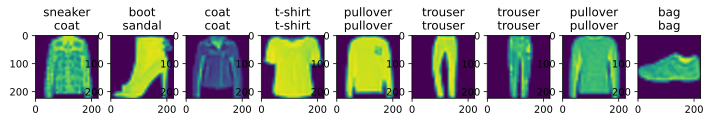

In [34]:
def get_fashion_mnist_labels(labels):
  text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','sneaker','bag','ankle','boot']
  return [text_labels[int(i)] for i in labels]
def show_fashion_mnist(images,labels):
  display.set_matplotlib_formats('svg')
  _,imgs = plt.subplots(1,len(images),figsize=(12,12))
  for img,figture,lbl in zip(imgs,images,labels):
    img.imshow(figture.view((224,224)).numpy())
    img.set_title(lbl)
    img.axes.get_xaxis().set_visible(True)
    img.axes.get_yaxis().set_visible(True)
  plt.show()
x,y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(x.to(device)).argmax(dim=1).cpu().numpy())
title = [true+'\n'+pred for true,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(x[0:9],title[0:9])